In [1]:
import pandas as pd

Reading the dataset

In [41]:
json_file_path = "Electronics_5.json"
metadata_json_file_path = "meta_Electronics.json"
df = pd.read_json(json_file_path , lines=True)
df_meta = pd.read_json(metadata_json_file_path , lines=True)

Considering only the columns which we need 

In [42]:
df = df[['asin', 'overall', 'reviewTime', 'reviewerID' ,'reviewText']]
df_meta = df_meta[['asin', 'title', 'brand', 'category']]
df.to_pickle('/home/jyoti/data.pkl')
df_meta.to_pickle('/home/jyoti/metadata.pkl')

In [32]:
df_meta = pd.read_pickle('/home/jyoti/metadata.pkl')
df = pd.read_pickle('/home/jyoti/data.pkl')

In [33]:
df = df.dropna()

Choosing a category and remove all products in metadata which do not belong to it

In [37]:
category_name = "Headphones"

In [5]:
# make a new data_frame for all entries which category_name in category column
df_category= pd.DataFrame(columns = df_meta.columns)
for index, row in df_meta.iterrows():
    if category_name in row['category'] :
        df_category.loc[len(df_category)] = df_meta.loc[index]
# remove missing values
df_category = df_category.dropna()
# remove duplicate values
df_category = df_category.drop_duplicates(subset=['asin'])  
df_category.to_pickle('/home/jyoti/category.pkl')

In [34]:
df_category = pd.read_pickle('/home/jyoti/category.pkl')

remove all reviews which do not belong to the specific category

In [ ]:
# set of asin for the category
asin_set = set(df_category['asin'])
# keep only the rows which have asin in asin_set
df = df[df['asin'].isin(asin_set)]

Q-3/4) Statistics of the product

In [38]:
df['overall'] = df['overall'].astype(int)
good_reviews = 0
bad_reviews = 0
for index, row in df.iterrows():
    if row['overall'] >= 3:
        good_reviews += 1
    else:
        bad_reviews += 1
print("Total number of rows for the product category ", category_name, " is ", len(df_category))
print("Total number of reviews for the product category ", category_name, " is ", len(df))
print("Total number of unique products for the product category ", category_name, " is ", df_category['asin'].nunique())
print("Number of good reviews ", good_reviews)
print("Number of bad reviews ", bad_reviews)
print("Average rating for the category ", df['overall'].mean())

# Calulte frequency of each rating
rating_frequency = df['overall'].value_counts()
print(rating_frequency.sort_index().to_string())

Total number of rows for the product category  Headphones  is  30471
Total number of reviews for the product category  Headphones  is  372167
Total number of unique products for the product category  Headphones  is  30471
Number of good reviews  312041
Number of bad reviews  60126
Average rating for the category  4.00616658650552
overall
1     31616
2     28510
3     41427
4     75024
5    195590


Q-5) Preprocessing the text

In [39]:
acronym_dictionary = {
    "NASA": "National Aeronautics and Space Administration",
    "FBI": "Federal Bureau of Investigation",
    "CIA": "Central Intelligence Agency",
    "UNESCO": "United Nations Educational, Scientific and Cultural Organization",
    "NATO": "North Atlantic Treaty Organization",
    "WHO": "World Health Organization",
    "IMF": "International Monetary Fund",
    "UNICEF": "United Nations International Children's Emergency Fund",}

In [40]:
import re
import nltk
from nltk.stem import WordNetLemmatizer

def pre_process(text):
    # lowercase
    text = text.lower()
    #remove tags
    text = re.sub("<!--?.*?-->","",text)
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    # replace acronym with full form
    for key, value in acronym_dictionary.items():
        text = text.replace(key, value)
    #lemitze text
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(text)

    return text

# Preprocess the reviewText column
df['reviewText'] = df['reviewText'].apply(pre_process)

In [67]:
#calculate number of reviews of each asin number
asin_review_count = df['asin'].value_counts()
# Calulate number of reviews for each brand
brand_set = set(df_category['brand'])
brand_review_count = {}
for brand in brand_set:
    brand_review_count[brand] = 0

for index, row in df_category.iterrows():
    if row['asin'] in asin_review_count:
        brand_review_count[row['brand']] += asin_review_count[row['asin']]


In [83]:
sorted_brand_review_count = sorted(brand_review_count.items(), key=lambda x: x[1], reverse=True)
print("TOP 20 brands with most reviews")
print(*(item for item in sorted_brand_review_count[:20]), sep="\n")
print()
print()
print("Top 20 brands with least reviews")
print(*(item for item in sorted_brand_review_count[-20:]), sep="\n")

TOP 20 brands with most reviews
('Sony', 32955)
('Sennheiser', 21516)
('Bose', 9582)
('Plantronics', 8340)
('Skullcandy', 8316)
('JLAB', 7731)
('JVC', 7692)
('Audio-Technica', 6791)
('Philips', 6527)
('Panasonic', 6053)
('Koss', 5784)
('LG', 5624)
('Samsung', 5604)
('Mpow', 5480)
('Bluedio', 5132)
('MEE audio', 4644)
('Anker', 4290)
('Symphonized', 4284)
('TaoTronics', 4059)
('Klipsch', 4050)


Top 20 brands with least reviews
('i.VALUX', 0)
('MPF Products', 0)
('CAD', 0)
('SONCM', 0)
('W-Sound', 0)
('Rademax', 0)
('Raytek', 0)
('Welcome to Sophia shop,it fit for girls for boys for women for guys for teenagers for man for everyone. Lightweight and Durable headphone headset also fits your phone well.We will make great effort to provide you with more attractive ,colorful,fashion,cartoon,ultra slim earphone', 0)
('New Unbrand', 0)
('KEKH', 0)
('Link Depot', 0)
('iEazy', 0)
('Mobix', 0)
('Pugster', 0)
('ALSISK', 0)
('Boise', 0)
('Paris Business', 0)
('YAN HUA WU', 0)
('ThinkFreebies', 0)
(

In [72]:
# Calculate the number of good reviwes and bad reviews for each product use asin
asin_good_review_count = {}
for index, row in df.iterrows():
    asin = row['asin']
    if row['overall'] >= 3:
        if asin in asin_good_review_count:
            asin_good_review_count[asin] += 1
        else:
            asin_good_review_count[asin] = 1

# print the top product with most good reviews
sorted_asin_good_review_count = sorted(asin_good_review_count.items(), key=lambda x: x[1], reverse=True)
# Print its title also

for i in range(1):
    asin = sorted_asin_good_review_count[i][0]
    good_review_count = sorted_asin_good_review_count[i][1]
    title = df_category[df_category['asin'] == asin]['title'].values[0]
    print("Title: ", title, "Good Review Count: ", good_review_count)

Title:  Sony MDRZX100 Headphones (Black) Good Review Count:  2850


In [90]:
# Show the count of ratings for the product over 5 consecutive years.
df['reviewTime'] = pd.to_datetime(df['reviewTime'])
df['year'] = df['reviewTime'].dt.year
# Calculate the number of reviews for each year
year_review_count = df['year'].value_counts()
# Club 5 consecutive years together
year_review_count = year_review_count.groupby((year_review_count.index//5)*5).sum()
print("Number of reviews for each 5 consecutive years")
print(year_review_count.sort_index().to_string())

year
2015    88899
2016    85594
2014    54989
2017    43527
2013    31878
2018    16682
2012    15092
2011    10447
2010     7327
2009     6808
2008     4837
2007     3049
2006     1545
2005      893
2004      333
2003      123
2002       75
2001       45
2000       24
Name: count, dtype: int64 Number of reviews for each 5 consecutive years
year
2000       600
2005     17132
2010    119733
2015    234702


In [91]:
customer_count_year={}
for index, row in df.iterrows():
    year = row['year']
    reviewerID = row['reviewerID']
    if year in customer_count_year:
        customer_count_year[year].add(reviewerID)
    else:
        customer_count_year[year] = set()
        customer_count_year[year].add(reviewerID)


{2015: {'A2DBFR8HA7RPOB', 'AJOEU72WBOOIM', 'A13GQH5GW8JB26', 'A1P5PU3XZOACFD', 'A2TBRI1AEYT9BI', 'A26HJ1HP8TASO2', 'A1IXIOC8XCFT9T', 'ANZBRWF47NPSC', 'A29RRLOAAJLRZE', 'AFP1JNGHUVLKH', 'A2KK72PRA6TYCZ', 'A1BUWOQKOAGLDC', 'ABOIT0HHAPFLV', 'A1D7UE3ILUOIK0', 'A6BJCVLQ54ZYU', 'A2CJ1PJXXWMX30', 'ASITQMBQOHBDD', 'AXC4IELBYI3TV', 'A3KPH6TPCEX6BB', 'AC6LV5D2RKTIR', 'A1YCN4DL7O67OA', 'A1VTNU313PF5K1', 'A1SAXYQGRC74PX', 'A2DPX4PKSPJPBC', 'A176CVIXCM0KPG', 'A3HCJHRB7VFXOC', 'A1H8P1J34H1LC4', 'A270HNJCGXVDBY', 'A2IHKSN4OTV7TF', 'A1BL88EXX73MMG', 'ATH5Y2UDXUQCY', 'ASZBSVEDPFB21', 'A2JF7JIOX4XMCW', 'AFHOONHZBRRRU', 'A3BNSFBT4B61EF', 'A33HUZ9OH4UTFZ', 'AW0I12TEF88HC', 'AG7QW8QGOX69K', 'A1HOO28UA8BPD5', 'A2WFVVI8NDLOUW', 'A3V3YVNCXUCQ3Q', 'A1KOCUCWRG0944', 'A1AR9QA7N67UR5', 'A80ZMCO43H6LV', 'AUXBPOTWTQIUU', 'A35YDLLSCZW47R', 'A2ST9YBI4R1S79', 'A1ZHNJW62JVYOF', 'A4XMVNT0BE54I', 'A3S052PAWRNLOZ', 'A22UX5L1S7CQ1K', 'A1V68JBU0IB1SU', 'A2WOKO9DGACCVL', 'A1M92239OM8KPO', 'A3V46SZDO9FXQI', 'A3VS15XK4LT6RO', 

In [93]:
for i in dict(sorted(customer_count_year.items())):
    print("Year: ", i, "Number of customers: ", len(customer_count_year[i]))

Year:  2000 Number of customers:  17
Year:  2001 Number of customers:  42
Year:  2002 Number of customers:  67
Year:  2003 Number of customers:  113
Year:  2004 Number of customers:  300
Year:  2005 Number of customers:  778
Year:  2006 Number of customers:  1337
Year:  2007 Number of customers:  2646
Year:  2008 Number of customers:  3611
Year:  2009 Number of customers:  4893
Year:  2010 Number of customers:  5682
Year:  2011 Number of customers:  8297
Year:  2012 Number of customers:  11991
Year:  2013 Number of customers:  24992
Year:  2014 Number of customers:  42386
Year:  2015 Number of customers:  66205
Year:  2016 Number of customers:  66197
Year:  2017 Number of customers:  36391
Year:  2018 Number of customers:  14770


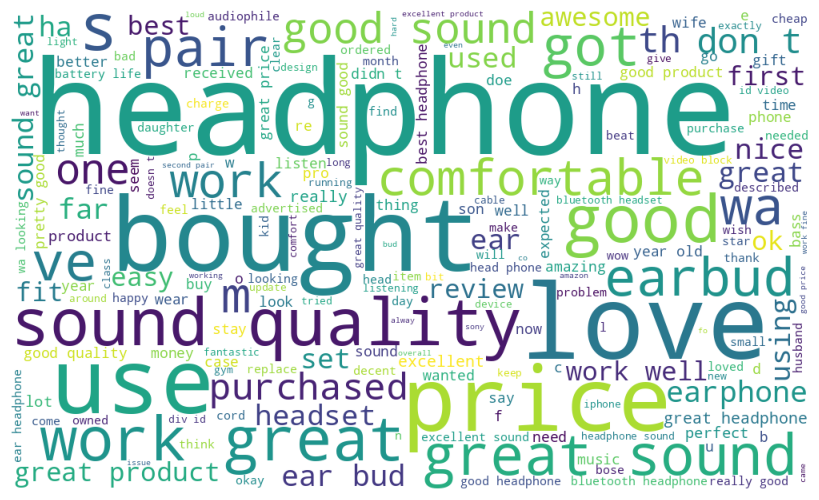

In [44]:
# Generate word cloud for good reviews
from wordcloud import WordCloud
import matplotlib.pyplot as plt
good_reviews = df[df['overall'] >= 3 ]
good_reviews_text = good_reviews['reviewText'].to_string()
word_cloud = WordCloud(width=1000, height=600, background_color='white').generate(good_reviews_text)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


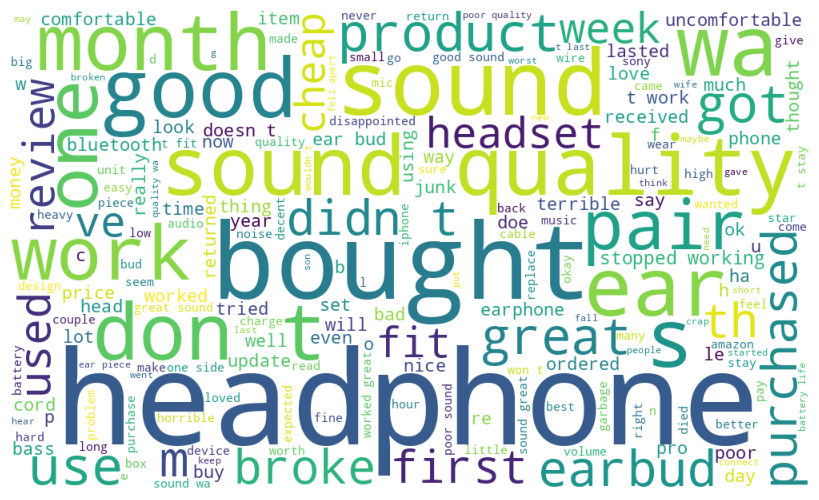

In [46]:
# Generate word cloud for good reviews
from wordcloud import WordCloud
import matplotlib.pyplot as plt
bad_reviews = df[df['overall'] < 3 ]
bad_reviews_text = bad_reviews['reviewText'].to_string()
word_cloud = WordCloud(width=1000, height=600, background_color='white').generate(bad_reviews_text)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


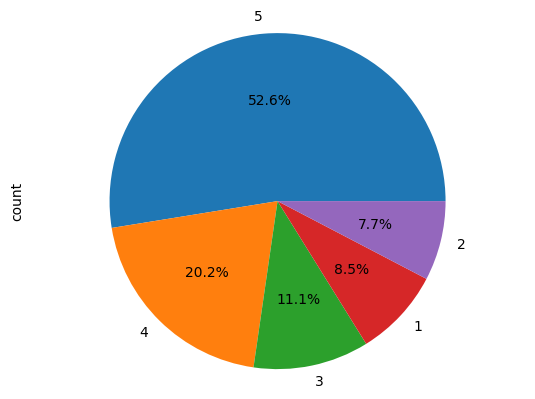

In [84]:
# Plot a pie chart for Distribution of Ratings vs. the No. of Reviews.
import matplotlib.pyplot as plt
rating_frequency = df['overall'].value_counts()
rating_frequency.plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')
plt.show()


In [47]:
df['overall_class'] = df['overall'].apply(lambda x: 'good' if x > 3 else 'average' if x == 3 else 'bad')
print(df['overall_class'].value_counts())

overall_class
good       270614
bad         60126
average     41427
Name: count, dtype: int64


In [48]:
# Divide the data into Train and Test Data in the ratio of 75:25.
from sklearn.model_selection import train_test_split
X = df['reviewText']
y = df['overall_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# # Create a pipeline to classify the reviews as good, average or bad
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train = X_train.fillna(' ')
X_test = X_test.fillna(' ')
vectorizer = TfidfVectorizer(max_features=20000)  # You can adjust max_features based on your dataset size
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [49]:

# # Train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42,n_jobs=-1)
rf_classifier.fit(X_train_vec, y_train)
# # Predict on the test set
y_pred = rf_classifier.predict(X_test_vec)
# # Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     average       0.82      0.10      0.18     10256
         bad       0.84      0.43      0.57     14985
        good       0.80      0.99      0.89     67801

    accuracy                           0.80     93042
   macro avg       0.82      0.51      0.55     93042
weighted avg       0.81      0.80      0.76     93042



In [50]:
# # Train the Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_vec, y_train)
# # Predict on the test set
y_pred = dt_classifier.predict(X_test_vec)
# # Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

     average       0.30      0.28      0.29     10256
         bad       0.55      0.54      0.54     14985
        good       0.86      0.87      0.86     67801

    accuracy                           0.75     93042
   macro avg       0.57      0.56      0.56     93042
weighted avg       0.74      0.75      0.75     93042



In [53]:
# Train the : Logistic Regression classifier
from sklearn.linear_model import LogisticRegression
lr_classifier = LogisticRegression(max_iter = 1000,random_state=42 , n_jobs=-1)
lr_classifier.fit(X_train_vec, y_train)
# Predict on the test set
y_pred = lr_classifier.predict(X_test_vec)
# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

     average       0.47      0.20      0.28     10256
         bad       0.74      0.72      0.73     14985
        good       0.88      0.96      0.92     67801

    accuracy                           0.84     93042
   macro avg       0.69      0.63      0.64     93042
weighted avg       0.81      0.84      0.82     93042



In [54]:
# Train the : Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vec, y_train)
# Predict on the test set
y_pred = nb_classifier.predict(X_test_vec)
# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

     average       0.53      0.00      0.01     10256
         bad       0.84      0.31      0.46     14985
        good       0.77      0.99      0.87     67801

    accuracy                           0.78     93042
   macro avg       0.71      0.44      0.44     93042
weighted avg       0.76      0.78      0.71     93042



In [55]:
# train the k-NN classifier
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors=5 , n_jobs=-1)
knn_classifier.fit(X_train_vec, y_train)
# Predict on the test set
y_pred = knn_classifier.predict(X_test_vec)
# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

     average       0.32      0.05      0.09     10256
         bad       0.62      0.13      0.22     14985
        good       0.75      0.98      0.85     67801

    accuracy                           0.74     93042
   macro avg       0.56      0.39      0.38     93042
weighted avg       0.68      0.74      0.66     93042



Q-11) 

In [6]:
# remove users who have given less than 5 reviews
user_review_count = df['reviewerID'].value_counts()
user_review_count = user_review_count[user_review_count >= 5]
df = df[df['reviewerID'].isin(user_review_count.index)]

# remove items which have less than 5 reviews
item_review_count = df['asin'].value_counts()
item_review_count = item_review_count[item_review_count >= 5]
df = df[df['asin'].isin(item_review_count.index)]

In [10]:
print("Number of unique products with reviews" ,df['asin'].nunique())
print("Number of unique users " ,df['reviewerID'].nunique())

Number of unique products with reviews 2089
Number of unique users  5957


In [20]:
import numpy as np
def cosine_similarity(matrix):
    dot_product = np.dot(matrix, matrix.T)
    norms = np.linalg.norm(matrix, axis=1)
    norm_outer = np.outer(norms, norms)
    epsilon = 1e-9
    cosine_sim = dot_product / (norm_outer + epsilon)
    return cosine_sim

def get_top_n_similar(id,similarity_matrix, n=5 ):
    similar_neighbors = similarity_matrix[id].sort_values(ascending=False).index[1:n+1]
    return similar_neighbors

In [18]:
# use K fold cross validation 
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import KFold

def run_K_fold(choice , similarities_df, user_item_rating_matrix_scaled):
    kf = KFold(n_splits=5,shuffle=True, random_state=42)
    K = [10,20,30,40,50]
    errors =[]
    for i in K:
        error = 0
        for train_index, test_index in kf.split(similarities_df):
            temp_error = 0
            train_df = similarities_df.iloc[train_index]
            test_df = similarities_df.iloc[test_index]
            for index, row in test_df.iterrows():
                # print(test_df[index])
                # break
                similar_users = get_top_n_similar(index, train_df, i)
                # average_rating = user_item_rating_matrix_scaled[user_item_rating_matrix_scaled[index] != 0][index].mean()
                # print(average_rating)
                predicted_rating = 0
                actual_rating = 0

                for index1, row1 in user_item_rating_matrix_scaled.iterrows():
                    if row1[index] != 0:
                        actual_rating = row1[index]
                        temp_list = []
                        for user in similar_users:
                            if row1[user] != 0:
                                temp_list.append(row1[user])
                        if len(temp_list) > 0:
                            predicted_rating = np.mean(temp_list)
                        else:
                            predicted_rating = 0.5
                temp_error += abs(predicted_rating - actual_rating)
            error += temp_error/len(test_df)
            #   
        print("Mean Absolute Error for ", i, " similar" , choice, " is ", error/5)
        errors.append(error/5)
    return errors

In [21]:
# Use minMaxScaler to scale the ratings
from sklearn.preprocessing import MinMaxScaler

def recommender_system(choice , df):
    if (choice == "user"):
        user_item_rating_matrix = df.pivot_table(index='asin', columns='reviewerID', values='overall' , fill_value=0)
        
    if (choice == "item"):
        user_item_rating_matrix = df.pivot_table(index='reviewerID', columns='asin', values='overall' , fill_value=0)

    scaler = MinMaxScaler()
    user_item_rating_matrix_scaled = scaler.fit_transform(user_item_rating_matrix)
    
    similarities = cosine_similarity(user_item_rating_matrix_scaled.transpose())
    user_item_rating_matrix_scaled = pd.DataFrame(user_item_rating_matrix_scaled , index=user_item_rating_matrix.index, columns=user_item_rating_matrix.columns)
    similarities_df = pd.DataFrame(similarities, index=user_item_rating_matrix_scaled.columns, columns=user_item_rating_matrix_scaled.columns)
    errors = run_K_fold(choice, similarities_df, user_item_rating_matrix_scaled)
    return errors

In [22]:
K = [10,20,30,40,50]
error_user = recommender_system("user", df)


Mean Absolute Error for  10  similar user  is  0.1759167611095936
Mean Absolute Error for  20  similar user  is  0.1669834686175381
Mean Absolute Error for  30  similar user  is  0.1701075569402108
Mean Absolute Error for  40  similar user  is  0.17290340538012405
Mean Absolute Error for  50  similar user  is  0.17768087439108357


In [23]:
error_item = recommender_system("item", df)

Mean Absolute Error for  10  similar item  is  0.20524742693883144
Mean Absolute Error for  20  similar item  is  0.18807160287871058
Mean Absolute Error for  30  similar item  is  0.1857834328440021
Mean Absolute Error for  40  similar item  is  0.18407792826599004
Mean Absolute Error for  50  similar item  is  0.18461724037542737


In [24]:
print("User based collaborative filtering")
for i in range(len(K)):
    print("Mean Absolute Error for ", K[i], " similar users is ", error_user[i])

print("Item based collaborative filtering")
for i in range(len(K)):
    print("Mean Absolute Error for ", K[i], " similar items is ", error_item[i])

User based collaborative filtering
Mean Absolute Error for  10  similar users is  0.1759167611095936
Mean Absolute Error for  20  similar users is  0.1669834686175381
Mean Absolute Error for  30  similar users is  0.1701075569402108
Mean Absolute Error for  40  similar users is  0.17290340538012405
Mean Absolute Error for  50  similar users is  0.17768087439108357
Item based collaborative filtering
Mean Absolute Error for  10  similar items is  0.20524742693883144
Mean Absolute Error for  20  similar items is  0.18807160287871058
Mean Absolute Error for  30  similar items is  0.1857834328440021
Mean Absolute Error for  40  similar items is  0.18407792826599004
Mean Absolute Error for  50  similar items is  0.18461724037542737


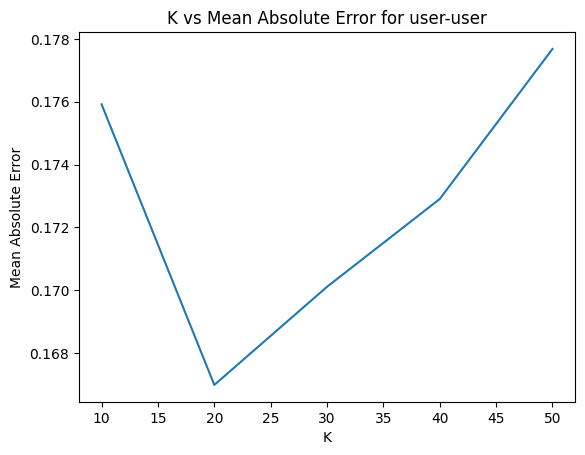

In [30]:
# Plot K vs Error
import matplotlib.pyplot as plt
plt.plot(K, error_user)
plt.xlabel('K')
plt.ylabel('Mean Absolute Error')
plt.title('K vs Mean Absolute Error for user-user')
plt.show()

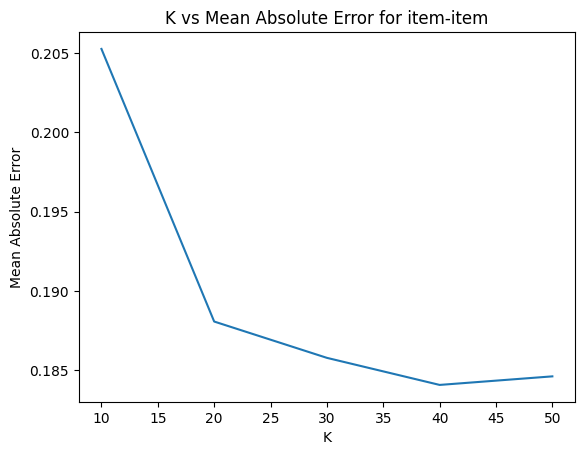

In [31]:
# Plot K vs Error
import matplotlib.pyplot as plt
plt.plot(K, error_item)
plt.xlabel('K')
plt.ylabel('Mean Absolute Error')
plt.title('K vs Mean Absolute Error for item-item')
plt.show()

Q-12

In [29]:
# Report top 10 products by User Sum Ratings.
user_item_rating_matrix = df.pivot_table(index='asin', columns='reviewerID', values='overall' , fill_value=0)
user_sum_ratings = user_item_rating_matrix.sum(axis=1)
top_10_products = user_sum_ratings.sort_values(ascending=False).head(10)

print("Top 10 products by User Sum Ratings")
for index, value in top_10_products.items():
    title = df_category[df_category['asin'] == index]['title'].values[0]
    print("Title: ", title, "Sum of Ratings: ", value)




Top 10 products by User Sum Ratings
Title:  Toysdone Wireless Headphones Stereo Earbuds Wireless Sport Earphones for Running with Mic (6 Hours Play Time, IPX4 Sweatproof, Secure Ear Hooks Design)-Black/Green Sum of Ratings:  1165.0
Title:  Xbrn Dual Ports Adapter Splitter, 2 in 1 Headphone Jack Aux Audio &amp; Charger Adapter Cable Connector Compactible for Ip7/ 7 Plus/ 8/Plus/X (Support Calling + Sync + Music Control + Charge) Sum of Ratings:  1111.0
Title:  Sony MDRZX100 Headphones (Black) Sum of Ratings:  1078.0
Title:  Sony MDRZX100 ZX Series Stereo Headphones (Blue) Sum of Ratings:  1078.0
Title:  Koss Porta Pro On Ear Headphones with Case, Black / Silver Sum of Ratings:  659.0
Title:  Sony MDR7506 Professional Large Diaphragm Headphone Sum of Ratings:  563.0
Title:  Sennheiser HD 202 II Professional Headphones (Black) Sum of Ratings:  478.0
Title:  Clip Style Headphone Black Lightweight and Comfortable Ear Clip. Splash Proof Water resistant Powerful Sound with Bass Boost JVC HAEB